<a href="https://colab.research.google.com/github/charlesreid1/dib-deep-chem/blob/master/ch6/keras_ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6 Redux: Keras, Not DeepChem

Walk through Chapter 6 examples using Keras instead of DeepChem.

The DeepChem custom data loader classes mostly use `joblib`under the hood. `joblib` allows the data sets to be stored in a compressed format (similar to a pickle but more efficient).

In [0]:
import os
import math

# For loading data sets
import joblib

# For making plots and stuff
import matplotlib.pyplot as plt
import seaborn as sns

# ROC curve
from sklearn.metrics import roc_curve

In [0]:
# Make sure we're using the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

We should also install [keras-metrics](https://pypi.org/project/keras-metrics/) to give us a wider selection of metrics. (Unfortunately, the keras developers have strong opinions about whether metrics should be included or not, e.g., [Github issue](https://github.com/keras-team/keras/issues/5794), so we have to resort to an external package to implement these.)

In [3]:
!pip install keras-metrics

In [4]:
import keras_metrics as km

Using TensorFlow backend.


# Transcription Factor Example



## Overview

This example will use a data set about a transcription factor called JUND. The data set used in this example comes from the human chromosome 22 (the smallest human chromosome). It is 50 Mbp.

The chromosome is broken into short segments of 101 base pairs.

One hot encoding is used to represent the sequences (i.e., each base pair is turned into a vector of 0s and 1s).

In [5]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

Cloning into 'DeepLearningLifeSciences'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 24), reused 85 (delta 17), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

## 1D Convolutional Neural Networks

Beacuse we are dealing with a 1D sequence of data, we use a convolutional neural network (CNN) that performs the convolution in 1 dimension (1D CNN).

(A 2D convolutional neural network would be good for spatial or image data, while a 3D convolutional neural network would be good for volumetric data.)

Typically, 1D convolutional neural networks have the following layers:

* Convolution layer, or (for 2D CNN) multiple convolution layers followed by a pooling layer

* Dropout layer (optional)

* Flatten layer (all output becomes 1D)

* Dense layer (everything-connected-to-everything network; number of dense output neurons = number of classes)

**Strategy:** We start by implementing a 1D CNN using the architecture in Chapter 6 of <u>Deep Learning for the Life Sciences</u>. We then implement another 1D CNN model using an example from the [Keras documentation](https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions) for sequence classification using Keras. It uses a different sequence of layers.

## Chapter 6 1D CNN

Before we get to the CNN layers, we start with some imports and setup:

In [0]:
import numpy as np

import keras

from keras import metrics

from keras.models import Sequential, Model
from keras.layers import Flatten, Embedding, Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

Now we bypass the DeepChem `DiskDataset` class to load the data set directly using joblib:

In [0]:
def load_dataset(which_dataset):
    import os
    
    if which_dataset not in ['train','valid','test']:
        raise Exception("Error: can only load datasets 'train', 'valid', or 'test', you specified %s"%(which_dataset))
    
    # Set data directory name
    data_dir = "%s_dataset"%(which_dataset)
    
    # Set filenames for X, y, w, labels
    base_filename = "shard-0-%s.joblib"
    X_filename    = os.path.join(data_dir,base_filename%("X"))
    y_filename    = os.path.join(data_dir,base_filename%("y"))
    w_filename    = os.path.join(data_dir,base_filename%("w"))
    ids_filename  = os.path.join(data_dir,base_filename%("ids"))
    
    X = joblib.load(X_filename)
    y = joblib.load(y_filename)
    w = joblib.load(w_filename)
    ids = joblib.load(ids_filename)
    
    return X, y, w, ids

In [9]:
train = load_dataset('train')
valid = load_dataset('valid')
test = load_dataset('test')

X_train, y_train, w_train, ids_train = load_dataset('train')
X_valid, y_valid, w_valid, ids_valid = load_dataset('valid')
X_test, y_test, w_test, ids_test = load_dataset('test')

n_train_obs = np.shape(X_train)[0]
n_valid_obs = np.shape(X_valid)[0]
n_test_obs = np.shape(X_test)[0]

print('-'*20)
print('training data shape:')
print(np.shape(X_train))
print(np.shape(y_train))
print('-'*20)
print('validation data shape:')
print(np.shape(X_valid))
print(np.shape(y_valid))
print('-'*20)
print('test data shape:')
print(np.shape(X_test))
print(np.shape(y_test))

--------------------
training data shape:
(276216, 101, 4)
(276216, 1)
--------------------
validation data shape:
(34527, 101, 4)
(34527, 1)
--------------------
test data shape:
(34528, 101, 4)
(34528, 1)


In [10]:
print(type(y_test[0][0]))

<class 'numpy.int64'>


### 1D Convolutional Neural Net Implementation

We have translated the example for DeepChem to Keras as best we can.

Keras documentation links:
* [Conv1D layer](https://keras.io/layers/convolutional/)
* [MaxPooling1D layer](https://keras.io/layers/pooling/)

The 1D convolutional neural net in Chapter 6 has the following layers:



In [11]:
features = 4
seq_length = 101
convolution_window = 10
n_filters = 15

model = Sequential()

# Unroll the book's for loop

# Convolution layer 1
model.add(Conv1D(n_filters, convolution_window, 
                 activation='relu', padding='same', 
                 input_shape=(seq_length, features)))

model.add(Dropout(0.5))

# Convolution layer 2
model.add(Conv1D(n_filters, convolution_window, 
                 activation='relu', padding='same'))

model.add(Dropout(0.5))

# Convolution layer 3
model.add(Conv1D(n_filters, convolution_window, 
                 activation='relu', padding='same'))

model.add(Dropout(0.5))

# Flatten to 1D
model.add(Flatten())

# Shrink to 1 neuron for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy','binary_crossentropy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Side Note:** as per [this Keras issue](https://github.com/keras-team/keras/issues/3230), the ROC AUC cannot be implemented directly as a metric by Keras because the metrics must be symbolic. We show how to plot the ROC curve in post-processing below.

Now train the model:

In [12]:
# Train the model for 10 epochs,
# then evaluate/save the ROC curve
num_epochs = 10
hist = model.fit(X_train, y_train,
                 batch_size=1000, 
                 epochs=num_epochs,
                 verbose = 0,
                 validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.


Now we can visualize the performance of the binary classification task using the ROC (receiver operating characteristic) curve, which shows true positives versus false positives - focusing on the O(100) positive instances, rather than all 30,000+ data points. The closer to x = y the curve gets, the worse it performs. Ideally we have a large area under the curve.

The sklearn package has the ROC curve as a built-in metric:

No handles with labels found to put in legend.


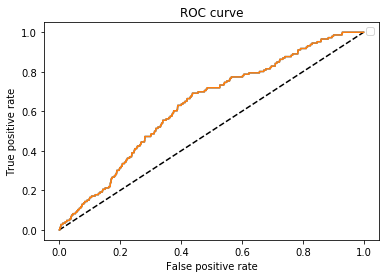

In [13]:
# Useful function for plotting the ROC curve
from sklearn.metrics import roc_curve

# Get model predictions on test data
y_model = model.predict(X_test).ravel()

# Form the ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_model)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

...it's not so good.

If we call the `evaluate()` method on the model, it returns the loss value and metrics values for the model in test mode.

Here are the loss value and accuracy for our model run on the test data:

In [14]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Loss value: %0.4f"%(scores[0]))
print("Accuracy: %0.4f"%(scores[1]))

Loss value: 0.0330
Accuracy: 0.9958


We have an accuracy of 99.5% - what's going on here? 

First, we have only 0s and 1s in our "true" output:

In [15]:
print(np.unique(y_test))

[0 1]


But the distribution of our two values are extremely skewed:

In [16]:
print(sum(y_test==0))
print(sum(y_test==1))

[34382]
[146]


Because less than 1% of the examples are positive examples, any metric that counts correct negative guesses toward the metric will be too high to be helpful. That's why the "accuracy" is so high when our ROC curve shows that the model actually stinks.

The model fit process saves out the history of the loss function and metrics at each epoch, so we can visualize those:

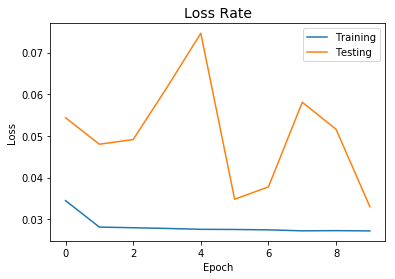

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Rate', size=14)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper right')
plt.show()

if False:
    plt.plot(hist.history['binary_crossentropy'])
    plt.plot(hist.history['val_binary_crossentropy'])
    plt.title('Binary Cross-Entropy', size=14)
    plt.ylabel('Binary Cross-Entropy')
    plt.xlabel('Epoch')
    plt.legend(['Training','Testing'], loc='lower right')
    plt.show()

# Using the Keras Example 1D CNN

The convolutional neural network proposed in Chapter 6 does not match the 1D convolutional neural net example contained in the Keras documentation [here](https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions), so before we move on to adding chromatin data, we try the Keras architecture, and see if there is a significant difference in performance.

**NOTE:** The main difference between the Keras 1D CNN and the Chapter 6 1D CNN is, the Chapter 6 1D CNN uses more dropout layers to prevent overfitting.

In [0]:
features = 4
seq_length = 101
convolution_window = 10
n_filters = 15

model2 = Sequential()

model2.add(Conv1D(n_filters, convolution_window,
                  activation='relu', padding='same',
                  input_shape=(seq_length, features)))

model2.add(Conv1D(n_filters, convolution_window,
                  activation='relu', padding='same'))

model2.add(MaxPooling1D(3))

model2.add(Conv1D(2*n_filters, convolution_window,
                  activation='relu', padding='same'))

model2.add(Conv1D(2*n_filters, convolution_window,
                  activation='relu', padding='same'))

model2.add(GlobalAveragePooling1D())

model2.add(Dropout(0.5))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Now fit the model to data as before:

In [19]:
# Train the model for 10 epochs,
# then evaluate/save the ROC curve
num_epochs = 10
hist2 = model2.fit(X_train, y_train,
                   batch_size=1000, 
                   epochs=num_epochs,
                   verbose = 1,
                   validation_data=(X_valid, y_valid))

Train on 276216 samples, validate on 34527 samples
Epoch 1/10
276216/276216 [==============================] - 3s 13us/step - loss: 0.0382 - acc: 0.9946 - val_loss: 0.0344 - val_acc: 0.9958
Epoch 2/10
276216/276216 [==============================] - 3s 9us/step - loss: 0.0329 - acc: 0.9958 - val_loss: 0.0318 - val_acc: 0.9958
Epoch 3/10
276216/276216 [==============================] - 3s 9us/step - loss: 0.0319 - acc: 0.9958 - val_loss: 0.0275 - val_acc: 0.9958
Epoch 4/10
276216/276216 [==============================] - 3s 9us/step - loss: 0.0313 - acc: 0.9958 - val_loss: 0.0314 - val_acc: 0.9958
Epoch 5/10
276216/276216 [==============================] - 3s 9us/step - loss: 0.0310 - acc: 0.9958 - val_loss: 0.0314 - val_acc: 0.9958
Epoch 6/10
276216/276216 [==============================] - 3s 9us/step - loss: 0.0302 - acc: 0.9958 - val_loss: 0.0267 - val_acc: 0.9958
Epoch 7/10
276216/276216 [==============================] - 3s 9us/step - loss: 0.0301 - acc: 0.9958 - val_loss: 0.0277 

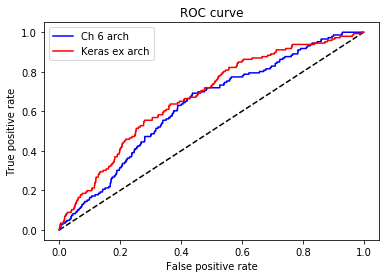

In [20]:
y_model1 = model.predict(X_test).ravel()
fpr1, tpr1, _ = roc_curve(y_test, y_model1)

y_model2 = model2.predict(X_test).ravel()
fpr2, tpr2, _ = roc_curve(y_test, y_model2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='Ch 6 arch', color='b')
plt.plot(fpr2, tpr2, label='Keras ex arch', color='r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The two models are virtually identical. This is not surprising - we would not expect a small change in the neural network architecture to drastically affect the model's ability to match the data.

# Adding Chromatin Accessibility Data

The poor performance of the sequential model is no reason to give up. Rather than fiddling with the layers and parameters, we should start by adding more data to the model.

Towards this end, we provide the model with additional data about availability of chromatin for each sequence. This requires making modifications to the neural network so it can take multiple inputs.

In [21]:
!ls DeepLearningLifeSciences/Chapter06/

chromatin.txt  tfbinding_chromatin.py  train_siRNA
rnai.py        tfbinding.py	       valid_dataset
test_dataset   train_dataset	       valid_siRNA


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

In [0]:
span_accessibility = {}
for line in open('chromatin.txt','r'):
    fields = line.split()
    span_accessibility[fields[0]] = float(fields[1])

In [0]:
def get_accessibility_data():
    """Load the chromatin accessibility data
    and return it as a Python dictionary indexed
    by sequence IDs.
    """
    # Load chromatin accessibility data
    accessibility = {}
    for line in open('chromatin.txt','r'):
        fields = line.split()
        accessibility[fields[0]] = float(fields[1])
    return accessibility

Now we need to add an additional input layer into the model. The book does this by adding one feature layer with one feature (the chromatin accessibility value), then concatenating the input to the final Flatten layer.

We build a new chromatin model with the book's architecture. However, this time we build the model differently: we use the Keras functional API (where layers are called as functions, with the prior layer passed as arguments). This allows us to create a layer that concatenates multiple inputs.

In [0]:
features = 4
seq_length = 101
convolution_window = 10
n_filters = 15

# The following creates a model using the Keras functional API
# (instead of using Sequential() and adding layers one at a time)

# Sequence portion of the neural net
sequence_input = Input(shape=(seq_length,features))

# Layers for sequential data
# 
# Layer 1
seq = Conv1D(n_filters, convolution_window, 
           activation='relu', padding='same')(sequence_input)
seq = Dropout(0.5)(seq)

# Layer 2
seq = Conv1D(n_filters, convolution_window, 
           activation='relu', padding='same')(seq)
seq = Dropout(0.5)(seq)

# Layer 3
seq = Conv1D(n_filters, convolution_window, 
           activation='relu', padding='same')(seq)
seq = Dropout(0.5)(seq)

# Flatten to 1D
seq = Flatten()(seq)

# Assemble the sequential network
seq = keras.Model(inputs=sequence_input, outputs=seq)

# Layer for chromatin input
chromatin_input = Input(shape=(1,))

# Create a concatenation layer
# that combines the output of the 
# 1D CNN with the chromatin coverage value
fin = keras.layers.concatenate([seq.output,chromatin_input])

fin = Dense(1,activation='sigmoid')(fin)

chromatin_model = keras.Model(inputs=[seq.input,chromatin_input], outputs=fin)

# Now compile the model
chromatin_model.compile(loss='binary_crossentropy',
                        optimizer='rmsprop',
                        metrics=[km.categorical_precision(), km.binary_precision(), km.binary_recall()])

Now our `chromatin_model` takes two inputs: one is our sequential input (as before), the other is the chromatin accessibility data.

### Keras Data Generator

In the DeepChem book, the custom `DiskDataset` class provided by DeepChem has a built-in method to iterate through the data in batches. Because we've switched to Keras, we have extra work to do to implement our own data generator function.

The sequence data generator can take any input arguments; each time it is called it should return a batch of data. When we fit our model to data, we should use the model function `fit_generator()` instead of `fit()`.

Hat tip to a [pyimagesearch blog post](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/) on this topic!

In [0]:
# A generator function that generates
# batches of input (sequence-plus-chromatin)
# and output (0/1 labels) data

def sequence_data_generator(mode, dataset, batch_size):
    """Generator function that returns one batch of data per call.
    The neural net model takes two inputs, so this should
    return a tuple, with the first input (one-hot encoded DNA 
    sequence) as the first item and the second input (chromatin
    accessibility) as the second item.
    
    Args:
        mode               String indicating generator mode
                           ("train" loops infinitely, "eval" stops at end)
        dataset            Which data set to load
                           ("train", "valid", "test")
        batch_size         Size of batch data returned
    """
    if mode not in ["train","eval"]:
        raise Exception("Invalid mode specified: must be 'train' or 'eval'")
    if dataset not in ["train","valid","test"]:
        raise Exception("Invalid dataset specified: must be 'train', 'valid', 'test'")
    
    # Because our data set is small enough,
    # we start by loading everything into
    # memory, and loop over it to return batches.
    data_dir = "%s_dataset"%(dataset)
    base_filename = "shard-0-%s.joblib"
    
    # Load sequence data
    X   = joblib.load(os.path.join(data_dir, base_filename%("X")))
    y   = joblib.load(os.path.join(data_dir, base_filename%("y")))
    w   = joblib.load(os.path.join(data_dir, base_filename%("w")))
    ids = joblib.load(os.path.join(data_dir, base_filename%("ids")))
    
    # Load chromatin accessibility data
    accessibility = get_accessibility_data()
    
    # Convert to numpy array
    chrom_accessibility = np.array([accessibility[k] for k in ids])
        
    # Get some useful numbers
    n_obs     = np.shape(X)[0]
    n_batches = math.ceil(n_obs/batch_size)
    if batch_size > n_obs:
        raise Exception("Invalid batch_size specified: larger than data set!")
    

    # Sequence data generators for keras 
    # should be infinite for training mode
    # and should stop for evaluation mode
    
    batch_start = 0
    batch_end = batch_start + batch_size
    
    # To assemble the batch:
    # - get the X and y values corresponding to these observations
    # - get the sequence IDs corresponding to observations
    # - convert the sequence IDs to a chromatin accessibility vector
    X_batch = X[batch_start:batch_end]
    y_batch = y[batch_start:batch_end]
    ids_batch = ids[batch_start:batch_end]
    acc_batch = np.array([accessibility[k] for k in ids_batch])
    yield ([X_batch,acc_batch], y_batch)
    
    while True:
        
        # Update indices
        batch_start = batch_end
        batch_end = batch_start + batch_size
        
        # Left and right halves of batch (X and chromatin access)
        X_batch = None
        y_batch = None
        ids_batch = None
        acc_batch = None
        
        if batch_end < n_obs:
            
            # Not at the end of the data set yet
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            ids_batch = ids[batch_start:batch_end]
            acc_batch = np.array([accessibility[k] for k in ids_batch])
            
        else:
            
            # Reached end of data set
            if mode=="train":
                # Loop back around forever
                batch_end = batch_end%n_obs
                sss = X[batch_start:]
                eee = X[:batch_end]
                X_batch   = np.concatenate([X[batch_start:],X[:batch_end]])
                y_batch   = np.concatenate([y[batch_start:],y[:batch_end]])
                ids_batch = np.concatenate([ids[batch_start:], ids[:batch_end]])
                acc_batch = np.array([accessibility[k] for k in ids_batch])
                
            elif mode=="eval":
                # Reset counter
                batch_end = 0
                # Stop short at the end
                X_batch   = X[batch_start:]
                y_batch   = y[batch_start:]
                ids_batch = ids[batch_start:]
                acc_batch = np.array([accessibility[k] for k in ids_batch])

        # Return a list of two inputs (to match the neural net architecture)
        # and one output, glued together in a tuple
        yield ([X_batch,acc_batch],y_batch)


In [0]:
batch_size = 1000

# We already know the size of the training, validation, and test sets
# because we loaded them into memory earlier in the notebook, and did this:
# n_train_obs = np.shape(X_train)[0]
# n_valid_obs = np.shape(X_valid)[0]
# n_test_obs = np.shape(X_test)[0]
# 
# However, to use a generator to get data from on disk, we would need
# metadata about the size of the dataset.

training_generator = sequence_data_generator(mode="train", 
                                             dataset="train", 
                                             batch_size=batch_size)

validation_generator = sequence_data_generator(mode="train", 
                                               dataset="valid", 
                                               batch_size=batch_size)

testing_generator = sequence_data_generator(mode="eval",
                                            dataset="test",
                                            batch_size=batch_size)

In [28]:
epochs = 20

# Fit the model to the data using the data generator
ch_hist = chromatin_model.fit_generator(training_generator,
                                        steps_per_epoch = n_train_obs // batch_size,
                                        validation_data = validation_generator,
                                        validation_steps = n_valid_obs // batch_size,
                                        epochs = epochs)


Epoch 1/20
276/276 [==============================] - 4s 15ms/step - loss: 0.0320 - precision: 0.0000e+00 - precision_1: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0469 - val_precision: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
276/276 [==============================] - 3s 12ms/step - loss: 0.0281 - precision: 0.0000e+00 - precision_1: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0445 - val_precision: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
276/276 [==============================] - 3s 12ms/step - loss: 0.0278 - precision: 0.0000e+00 - precision_1: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0396 - val_precision: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
276/276 [==============================] - 3s 12ms/step - loss: 0.0276 - precision: 0.0000e+00 - precision_1: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0379 - val_precision: 0.0000e+00 - val_precision_1: 0.0000e+00 - val

In [0]:
y_chmodel = chromatin_model.predict_generator(testing_generator, steps=(n_test_obs//batch_size) + 1)

fpr, tpr, _ = roc_curve(y_test, y_chmodel)

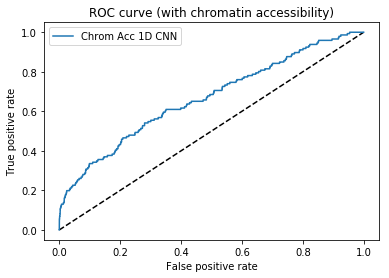

In [30]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Chrom Acc 1D CNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (with chromatin accessibility)')
plt.legend(loc='best')
plt.show()